# SF-DAT-21 | Unit Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in Unit Projects 1 and 2.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as pl
%matplotlib inline

In [3]:
df_raw = pd.read_csv("../../dataset/admissions.csv")
df = df_raw.dropna()
print df.shape
print df.head()

(397, 4)
   admit  gre   gpa  prestige
0      0  380  3.61         3
1      1  660  3.67         3
2      1  800  4.00         1
3      1  640  3.19         4
4      0  520  2.93         4


## Part 1. Frequency Tables

#### Question 1. Let's create a frequency table of our variables.

In [4]:
# frequency table for prestige and whether or not someone was admitted
freq = pd.crosstab(index=df['prestige'],columns=df['admit'])
freq 

admit,0,1
prestige,,
1,28,33
2,95,53
3,93,28
4,55,12


In [5]:
(freq/397.).round(2)

,0,1
prestige,,
1,0.07,0.08
2,0.24,0.13
3,0.23,0.07
4,0.14,0.03


## Part 2. Return of dummy variables

#### Question 2.1. Create class or dummy variables for prestige.

In [6]:
df.head(2)

,admit,gre,gpa,prestige
0,0,380,3.61,3
1,1,660,3.67,3


In [7]:
df.prestige.value_counts()

2    148
3    121
4     67
1     61
Name: prestige, dtype: int64

In [8]:
dummy_ranks = pd.get_dummies(df['prestige'],prefix='prestige')
dummy_ranks.head(2)

,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,0,1,0
1,0,0,1,0


#### Question 2.2. When modeling our class variables, how many do we need?

Answer: 3

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [95]:
cols_to_keep = ['admit', 'gre', 'gpa']
handCalc = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_1':])
print handCalc.head()

   admit  gre   gpa  prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380  3.61             0             0             1             0
1      1  660  3.67             0             0             1             0
2      1  800  4.00             1             0             0             0
3      1  640  3.19             0             0             0             1
4      0  520  2.93             0             0             0             1


In [109]:
print handCalc['prestige_1.0'].sum()
print handCalc['prestige_1.0'].value_counts()
print '\n'
print handCalc['admit'].sum()
print handCalc['admit'].value_counts()

61.0
0    336
1     61
Name: prestige_1.0, dtype: int64


126
0    271
1    126
Name: admit, dtype: int64


In [103]:
# crosstab prestige 1 admission
# frequency table cutting prestige and whether or not someone was admitted
freq = pd.crosstab(index=handCalc['prestige_1.0'],columns=handCalc['admit'], margins=True)
freq.columns = ['admit_no','admit_yes','rowtotal']
freq.index = ['prestige_0.0','prestige_1.0','columntotal']
freq

,admit_no,admit_yes,rowtotal
prestige_0.0,243,93,336
prestige_1.0,28,33,61
columntotal,271,126,397


#### Question 3.1. Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college.

In [104]:
odds_admitted_1 = 1. * 33 /28
odds_admitted_1

1.1785714285714286

#### Question 3.2. Now calculate the odds of admission if you did not attend a #1 ranked college.

In [105]:
odds_admitted_no1 = 1. * 93 / 243
odds_admitted_no1

0.38271604938271603

#### Question 3.3. Calculate the odds ratio.

In [106]:
odds_ratio = odds_admitted_1/odds_admitted_no1
odds_ratio

3.079493087557604

#### Question 3.4. Write this finding in a sentenance:

Answer: so odds of admission are about 3 times higher for students attended #1 ranked school

#### Question 3.5. Print the cross tab for prestige_4.

In [107]:
# crosstab prestige 1 admission
# frequency table cutting prestige and whether or not someone was admitted
freq2 = pd.crosstab(index=handCalc['prestige_4.0'],columns=handCalc['admit'], margins=True)
freq2.columns = ['admit_no','admit_yes','rowtotal']
freq2.index = ['prestige_0.0','prestige_4.0','columntotal']
freq2

,admit_no,admit_yes,rowtotal
prestige_0.0,216,114,330
prestige_4.0,55,12,67
columntotal,271,126,397


#### Question 3.6. Calculate the OR.

In [108]:
odds_admitted_4 = 1. * 12 / 55
odds_admitted_4
odds_admitted_no4 = 1. * 114 / 216
odds_admitted_no4
odds_ratio = odds_admitted_4/odds_admitted_no4
odds_ratio

0.4133971291866028

#### Question 3.7. Write this finding in a sentence.

Answer: so odds of admission are lower for students attended #4 ranked schools than students attended higher ranked schools. 

## Part 4. Analysis

In [16]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
print data.head()

   admit  gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380  3.61             0             1             0
1      1  660  3.67             0             1             0
2      1  800  4.00             0             0             0
3      1  640  3.19             0             0             1
4      0  520  2.93             0             0             1


We're going to add a constant term for our Logistic Regression.  The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [17]:
# manually add the intercept
data['intercept'] = 1.0

In [18]:
data.head(3)

,admit,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0,intercept
0,0,380,3.61,0,1,0,1
1,1,660,3.67,0,1,0,1
2,1,800,4.00,0,0,0,1


#### Question 4.1. Set the covariates to a variable called train_cols.

In [44]:
train_cols = ['intercept','gre','gpa','prestige_2.0','prestige_3.0','prestige_4.0']
#train_cols = ['gre','gpa','prestige_2.0','prestige_3.0','prestige_4.0']

#### Question 4.2. Fit the model.

In [45]:
from sklearn import linear_model

X = data[train_cols]
y = data['admit']

model = linear_model.LogisticRegression()
model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
X.head(2)

,intercept,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0
0,1,380,3.61,0,1,0
1,1,660,3.67,0,1,0


#### Question 4.3. Print the summary results.

In [47]:
model.intercept_

array([-1.09518905])

In [48]:
model.coef_

array([[-1.09518905,  0.00188666,  0.32452811, -0.6200671 , -1.16988125,
        -1.3847737 ]])

In [49]:
model.score(X,y)

0.7103274559193955

#### Question 4.4. Calculate the odds ratios of the coeffincients and their 95% CI intervals --- don't know how using sklearn so I switched to statsmodel

hint 1: np.exp(X)

hint 2: conf['OR'] = params

        conf.columns = ['2.5%', '97.5%', 'OR']

In [52]:
import statsmodels.api as sm
model2 = sm.Logit(y, X)
results = model2.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Sun, 03 Apr 2016   Pseudo R-squ.:                 0.08166
Time:                        14:54:59   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
================================================================================
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
intercept       -3.8769      1.142     -3.393      0.001        -6.116    -1.638
gre              0.0022      0.001      2.028      0.043      7.44e-05     0.004
gpa              0.7793      0.333      2.344      0.019         0.128     1.431
prestige_2.0    -0.6801      0.317     -2.146      0.032        -1.301    -0.059
prestige_3.0    -1.3387      0.345     -3.882      0.000        -2.015    -0.663
prestige_4.0    -1.5534      0.417     -3.721      0.000        -2.372    -0.735
================================================================================
"""

In [53]:
print np.exp(results.params)

intercept       0.020716
gre             1.002221
gpa             2.180027
prestige_2.0    0.506548
prestige_3.0    0.262192
prestige_4.0    0.211525
dtype: float64


In [55]:
params = results.params
conf = results.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

                  2.5%     97.5%        OR
intercept     0.002207  0.194440  0.020716
gre           1.000074  1.004372  1.002221
gpa           1.136120  4.183113  2.180027
prestige_2.0  0.272168  0.942767  0.506548
prestige_3.0  0.133377  0.515419  0.262192
prestige_4.0  0.093329  0.479411  0.211525


#### Question 4.5. Interpret the OR of Prestige_2.

Answer: The odds being admitted for students graduated from undergraduate school with prestige level 2 is 50% less than students graduated from schools with a level-1 prestige.  

#### Question 4.6. Interpret the OR of GPA.

Answer: The odds being admitted fro students with higher gpa is 1.18 times higher than students with low gpa. 

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values.  This will allow us to see how the predicted probability of admission increases/decreases across different variables.  First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa".  This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [57]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [58]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)

print gres
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])

gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)

print gpas
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])

# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


In [59]:
print combos.shape
combos.head(2)
combos.columns = ['gre','gpa','prestige','intercept']
combos.head(10)

(400, 4)


,gre,gpa,prestige,intercept
0,220,2.260000,1,1
1,220,2.260000,2,1
2,220,2.260000,3,1
3,220,2.260000,4,1
4,220,2.453333,1,1
5,220,2.453333,2,1
6,220,2.453333,3,1
7,220,2.453333,4,1
8,220,2.646667,1,1
9,220,2.646667,2,1


#### Question 5.1. Recreate the dummy variables.

In [60]:
train_cols = ['intercept','gre','gpa','prestige_2.0','prestige_3.0','prestige_4.0']

In [61]:
# recreate the dummy variables
prestige_df = pd.get_dummies(combos['prestige'],prefix='prestige')
prestige_df.head(5)
# keep only what we need for making predictions


,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0


In [62]:
predict_x = combos.join([prestige_df])

In [63]:
predict_x = predict_x[['intercept','gre','gpa','prestige_2.0','prestige_3.0','prestige_4.0']]

In [64]:
predict_x.head()
predict_x.tail()

,intercept,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0
395,1,800,3.806667,0,0,1
396,1,800,4.000000,0,0,0
397,1,800,4.000000,1,0,0
398,1,800,4.000000,0,1,0
399,1,800,4.000000,0,0,1


#### Question 5.2. Make predictions on the enumerated dataset.

In [65]:
model.predict(predict_x)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1,

#### Question 5.3. Interpret findings for the last 4 observations.

Answer:
* A student with 800 on gre, 4.00 on gpa, and from #1 got admitted. 

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

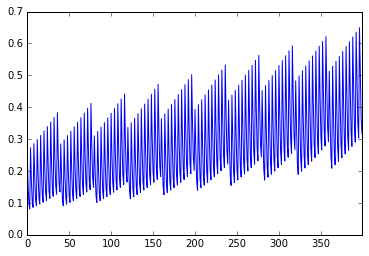

In [77]:
prob = model.predict_proba(predict_x)
prob_admitted = [row[1] for row in prob]
prob_admitted[:10]
pd.Series(prob_admitted).plot()